In [2]:
# Imports
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.spatial import distance
import pandas as pd
import numpy as np
from scipy.sparse import csgraph
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [88]:
# Kmeans
def Kmeans(X_train,N,pointIDs,iterations):
    X_train = pd.DataFrame(data=X_train)
#     centroid_initial = X_train.sample(N)
    centroid_initial = X_train.loc[pointIDs]
    X_train = X_train.to_numpy()
    centroid_initial = centroid_initial.to_numpy()
    centroid_old=[]
    for iterations in range(iterations):
        dict={}
        result={}
        for i in range(X_train.shape[0]):
            u= X_train[i]-centroid_initial
            sqDiffMat = np.square(u)
            sqDistances = (sqDiffMat.sum(axis=1))**0.5
            minDistanceIndex = np.argmin(sqDistances)
            minDistance = np.min(sqDistances)
            if minDistanceIndex in dict:
                dict[minDistanceIndex].append(X_train[i])
                result[minDistanceIndex].append(i)
            else:
                dict[minDistanceIndex] = [X_train[i]]
                result[minDistanceIndex]=[i]
        centroid_initial_new= [np.mean(i,axis=0) for i in dict.values()]
        diff = np.linalg.norm( np.array(centroid_initial_new) - np.array(centroid_initial))
#         if(diff < 0.001):
#             break;
        centroid_initial = centroid_initial_new
    Clusters = [np.array(xi) for xi in dict.values()]
    return result

# Spectral
def computeSimilarityMatrix(x_train, sigma):
    similarityMatrix = [[0 for x in range(len(x_train))] for y in range(len(x_train))]
    for point in range(len(x_train)):
        for p in range(len(x_train)):
            dist = np.linalg.norm(x_train[point] - x_train[p])
            similarityMatrix[point][p] = np.exp(-dist**2/(sigma**2.))
    return similarityMatrix

def sort_eig(eigenValues, eigenVectors):
        ev = np.array(eigenValues.argsort())
        delta = 0
        k = 0
        append_k = []
        for i in range(1, len(eigenValues)):
            tmp = abs(eigenValues[ev[i]] - eigenValues[ev[i-1]])
            if tmp > delta:
                k = ev[i]
                delta = tmp
        idx = ev[:k+1]
        eigenVectors = eigenVectors[:,idx]
        return eigenVectors,k

# Hierarchical Agglomerative Clustering

def hierarchical(X_train):
    distance_matrix = distance.cdist(X_train, X_train, 'euclidean')
    return distance_matrix


def find_min(dist_mat):
    i=dist_mat[dist_mat>0].min(axis=1).argmin()
    j=dist_mat[dist_mat>0].idxmin(axis=0).iloc[i]
    return i,j
    
#Density based Clustering

def regionQuery(p):
    NeighborPts=[]
    for i in range(len(distance_matrix)):
        if distance_matrix[p][i]<=eps:
            NeighborPts.append(i)
    return NeighborPts

def expandCluster(p, NeighborPts, Cno):
    C[Cno].append(p)
    pn=0
    while(pn<len(NeighborPts)):
        if visited[NeighborPts[pn]] == "U":
            visited[NeighborPts[pn]] = 'V'
            np_NeighborPts = regionQuery(NeighborPts[pn])
            if len(np_NeighborPts) >= minPts:
                for pt in np_NeighborPts:
                    if pt not in NeighborPts:
                        NeighborPts.append(pt)
            
        flag=0
        for h in C.keys():
            if NeighborPts[pn] not in C[h]:
                continue
            else:
                flag=1
                break
        if flag==0:
            C[Cno].append(NeighborPts[pn])
        pn=pn+1

    return C

def density_based():
    Cno = 0
    for p in range(len(x)):
        if visited[p] == 'U':
            visited[p] = 'V'
            NeighborPts = regionQuery(p)
            if len(NeighborPts) < minPts:
                flag=0
                for h in C.keys():
                    if p not in C[h]:
                        continue
                    else:
                        flag=1
                        break
                if flag==0:
                    continue
            else:
                expandCluster(p,NeighborPts,Cno)
                Cno+=1
# Gaussian Based
def m_step(r):
    m_c = []
    for c in range(len(r[0])):
        m = np.sum(r[:,c])
        m_c.append(m)
    pi_c = []
    for m in m_c:
        pi_c.append(m/np.sum(m_c))   

    mu_c = np.dot(r.T,x)/np.array(m_c).reshape(-1,1)

    var_c = []

    for c in range(len(r[0])):
        var_c.append((1/m_c[c])*np.dot(((r[:,c].reshape(x.shape[0],1))*(x-mu_c[c])).T,(x-mu_c[c])))

    temp_lik = [pi_c[z] * np.array(multivariate_normal.pdf(x,mean=mu_c[z],cov=var_c[z]+smooth, allow_singular=True)) for z in range(k)]
    log_lik = np.log(np.sum(np.array(temp_lik)))
    return pi_c,mu_c,var_c+smooth,log_lik
    
def e_step(pi_c,mu_c,var_c):
    final_r_log=np.zeros((x.shape[0], k))
    g_sum = np.sum([pi_c[z] * np.array(multivariate_normal.pdf(x,mean=mu_c[z],cov=var_c[z]+smooth, allow_singular=True)) for z in range(k)],axis=0)
    for i in range(k):
        g = pi_c[i] * np.array(multivariate_normal.pdf(x,mean=mu_c[i],cov=var_c[i]+smooth, allow_singular=True))
        final_r_log[:,i] = g/g_sum
    return final_r_log
    
# Coefficients
def dict_list(dic):
    y_pred_list = []
    for c,i in dic.items():
        for j in i:
            y_pred_list.append([c,j])
    return sorted(y_pred_list,key=lambda x: (x[1]))

def jaccardAndRand(y_true_matrix,y_pred_matrix):
    m11 = 0
    m00 = 0
    m10 = 0
    m01 = 0
    for i in range(len(x)):
        for j in range(len(x)):
            if y_pred_matrix[i][j] == 1 and y_true_matrix[i][j] == 1:
                m11 += 1
            if y_pred_matrix[i][j] == 0 and y_true_matrix[i][j] == 0:
                m00 += 1
            if y_pred_matrix[i][j] == 1 and y_true_matrix[i][j] == 0:
                m10 += 1
            if y_pred_matrix[i][j] == 0 and y_true_matrix[i][j] == 1:
                m01 += 1
    rand = (m11 + m00) / (m11 + m00 + m10 + m01)
    jaccard = (m11) / (m11 + m10 + m01)
    print("Rand Index is", rand)
    print("Jaccard Coefficient is", jaccard)
    
            
def labelsArray_Dict(arr):
    d = defaultdict(list)
    for i in range(len(arr)):
        d[arr[i]].append(i)
    return d

def true_form_matrix(arr):
    d = defaultdict(list)
    for i in range(len(arr)):
        d[arr[i]].append(i)
    return list(d.values())

def form_matrix(mat):
    matrix=[[0 for i in range(len(x))] for j in range(len(x))]
    for i in mat:
        for j in i:
            for k in i:
                matrix[j][k]=1
    return matrix  
    
    
# Visualization
def visualize(x,l,titl):
    if (len(x[0]) > 2 ):
        pca_df = pd.DataFrame(pca(x,dict_list(l)), columns = ['PCA1','PCA2'])
    else:
        pca_df = pd.DataFrame(x, columns=['PCA1','PCA2'])
    cluster_df = pd.DataFrame(dict_list(l),columns=['Cluster','Id'])['Cluster']
    df = pd.concat([pca_df,cluster_df],axis=1)
    lm = sns.lmplot(x='PCA1',y='PCA2', data = df, fit_reg=False, hue='Cluster')
    plt.title(titl)
    plt.show()

def pca(x_train,y_pred):
    pca = PCA(n_components=2,svd_solver='full')
    pca.fit(x_train)
    pca = pca.transform(x_train)
    return pca

## Spectral Clustering

In [44]:
# Inputs for Spectral Clustering
sigma = 2.5
initialize_dataIDs= [10,20,30,40,50,60,70,80,90,200]
n_clusters = 11 # Number of clusters
n_iterations = 10 # Number of iterations
input_file='iyer.txt'
data = pd.read_csv(input_file, sep='\t', header=None)
x=data[data.columns[2:]]
y=data[data.columns[1]]
# initialize_dataIDs = X_train.sample(n_clusters)

Rand Index is 0.7513777222407207
Jaccard Coefficient is 0.28704309669667094


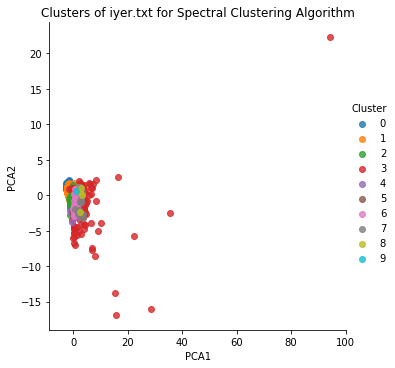

In [45]:
# Spectral Clustering
x=x.to_numpy()

dist_mat = computeSimilarityMatrix(x,sigma)
L = csgraph.laplacian(np.array(dist_mat))
eigval, eigvec = np.linalg.eig(L)
eigvec1, k = sort_eig(np.array(eigval),np.array(eigvec))
y_pred = Kmeans(pd.DataFrame(eigvec1),n_clusters,initialize_dataIDs,n_iterations)
y_pred_matrix = form_matrix(list(y_pred.values()))
y_true_matrix = form_matrix(true_form_matrix(y.to_numpy()))
jaccardAndRand(y_true_matrix,y_pred_matrix)
visualize(x,y_pred,"Clusters of "+input_file+" for Spectral Clustering Algorithm")

## KMeans

In [22]:
# Inputs for Kmeans
input_file='iyer.txt'
data = pd.read_csv(input_file, sep='\t', header=None)
x=data[data.columns[2:]]
y=data[data.columns[1]]

x=x.to_numpy()
n_clusters = 11 # Number of clusters
n_iterations = 20 # Number of iterations
initialize_dataIDs = [1,2,3,4,5,6,7,8,9,10,11] # Initial point IDs for the centroids

Rand Index is 0.8550632461492991
Jaccard Coefficient is 0.4298665175352102


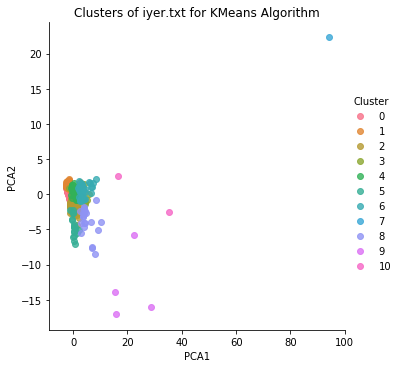

In [23]:
l=Kmeans(x,n_clusters,initialize_dataIDs,n_iterations) # Change number of clusters
y_pred_matrix = form_matrix(list(l.values())) # send list of lists 
y_true_matrix = form_matrix(true_form_matrix(y.to_numpy()))
jaccardAndRand(y_true_matrix,y_pred_matrix)
visualize(x,l,"Clusters of "+input_file+" for KMeans Algorithm")

## Hierarchical Agglomerative Clustering

In [6]:
# Inputs for Hierarchical Clustering
input_file='cho.txt'
data = pd.read_csv(input_file, sep='\t', header=None)
x=data[data.columns[2:]]
y=data[data.columns[1]]
x=x.to_numpy()
n_clusters = 5 #Number of clusters

Rand Index is 0.40427930951166474
Jaccard Coefficient is 0.24201537147736976


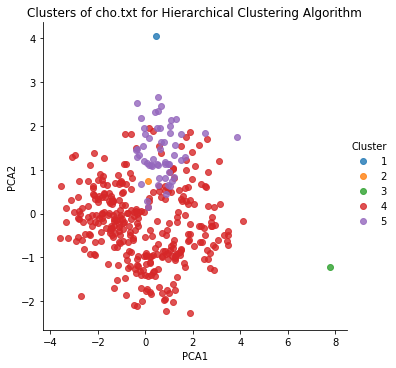

In [7]:
dm=np.array(hierarchical(x))
np.min(dm[np.nonzero(dm)])
dist_mat=pd.DataFrame(data=dm)

k = 1
while(dist_mat.shape[0]>n_clusters):
    i,colname_j = find_min(dist_mat)
    colname_i = dist_mat.columns[i]
    merge_col=str(colname_i)+"&"+str(colname_j) 
    x1 = dist_mat[[colname_i,colname_j]].min(axis=1)
    x1.name=merge_col
    dist_mat[merge_col] = x1  # add new col
    dist_mat = dist_mat.append(x1) # add new row
    dist_mat=dist_mat.drop(columns=[colname_i,colname_j]) # drop col
    dist_mat=dist_mat.drop([colname_i,colname_j]) # drop row
    k+=1
    
d_h = defaultdict(list)
k1=0
for i in list(dist_mat.columns):
    k1+=1
    temp = str(i).split('&')
    d_h[k1] = [int(j) for j in temp]

y_pred_matrix = form_matrix(list(d_h.values()))
y_true_matrix = form_matrix(true_form_matrix(y.to_numpy()))
jaccardAndRand(y_true_matrix,y_pred_matrix)
visualize(x,d_h,"Clusters of "+input_file+" for Hierarchical Clustering Algorithm")

## Density based Clustering

In [111]:
# Inputs for Density based clustering

input_file='iyer.txt'
data = pd.read_csv(input_file, sep='\t', header=None)
x=data[data.columns[2:]]
y=data[data.columns[1]]
x=x.to_numpy()

C = defaultdict(list)
visited=["U" for i in range(len(x))]
minPts=3 # As mentioned in the DemoDescription.pdf file.
eps=1 # # As mentioned in the DemoDescription.pdf file.


Rand Index is 0.6526755683922646
Jaccard Coefficient is 0.2835567491646023


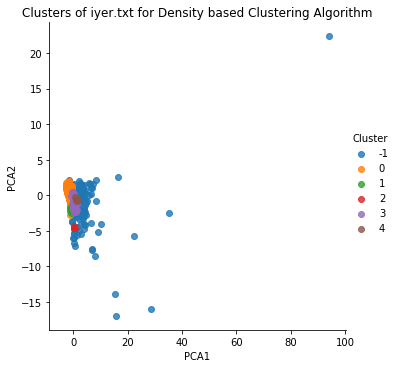

In [112]:
distance_matrix = distance.cdist(x, x, 'euclidean')
density_based()   
values = [item for sublist in list(C.values()) for item in sublist]
for i in range(len(x)):
    if i not in values:
        C[-1].append(i)

y_pred_matrix = form_matrix(list(C.values()))
y_true_matrix = form_matrix(true_form_matrix(y.to_numpy()))
jaccardAndRand(y_true_matrix,y_pred_matrix)
visualize(x,C,"Clusters of "+input_file+" for Density based Clustering Algorithm")


## Gaussian 

In [167]:
# Inputs for Gaussian
input_file = 'cho.txt'
data = pd.read_csv(input_file, sep='\t', header=None)
x=data[data.columns[2:]]
y=data[data.columns[1]]
x = x.to_numpy()

k=5 # number of clusters
pi = np.array([0.1, 0.2, 0.2, 0.3, 0.2 ])
mean = np.array([[0,0],[3,3],[0,4],[1,1],[2,3]])
cov = [[[1,0.4],[0.4,1]], [[1,0], [5,21]], [[1,0], [10,2]], [[1,1], [20,2]], [[0.4,0], [0,0.1]]]
# pi = np.array([1/k for i in range(k)]) # Prior cluster probabilities 
# random_row = np.random.randint(low=0, high=len(x), size=k)
# mean = np.array([  x[row_index,:] for row_index in random_row ]) # Mean array
# cov = [ np.cov(x.T) for _ in range(k) ] # Covariance Matrix


threshold_value = 1e-9 # The threshold value to check the difference between two consecutive log-likelihood values.
n_iterations = 35 # Number of iterations
smooth = 1e-9*np.ones(len(x[0])) # In order to prevent the occurrence of singular matrices, cov matrix should be replaced by cov+smooth_value*I, where "I" is an identity matrix.
                                    #threshold_value - The threshold value to check the difference between two consecutive log-likelihood values.


Rand Index is 0.64079572605976
Jaccard Coefficient is 0.20406888551797983


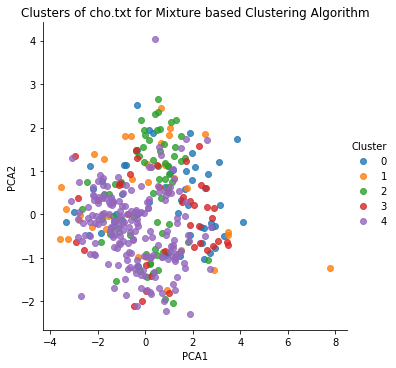

In [168]:
r_ini = np.array([[0 for i in range(k)] for j in range(len(x))])
for i in range(np.shape(r_ini)[0]):
    ind=np.random.randint(0, k)
    r_ini[i][ind]=1
log_li = [0]

for i in range(n_iterations):
    pi,mean,cov,log_lik = m_step(r_ini)
    r_ini = e_step(pi,mean,cov)
    log_li.append(log_lik)
    if log_li[-1] - log_li[-2] < threshold_value:
        break
labels = np.argmax(r_ini,axis=1)
y_pred_matrix = form_matrix(true_form_matrix(labels))
y_true_matrix = form_matrix(true_form_matrix(y.to_numpy()))
jaccardAndRand(y_true_matrix,y_pred_matrix)
visualize(x,labelsArray_Dict(labels),"Clusters of "+input_file+" for Mixture based Clustering Algorithm")